In this project we demostrate several dimension reduction models and compare the perfromance of KNN on the original dataset and the reduction dataset. We use the diabetes dataset from sklearn.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Load the diabetes dataset
diabetes_sklearn = load_diabetes()
## convert the diabete dataset to pandas form
data = pd.DataFrame(data= np.c_[diabetes_sklearn['data'], diabetes_sklearn['target']],
                     columns= diabetes_sklearn['feature_names'] + ['target'])
# Separate the features, target values, and feature names
X = data.drop('target', axis=1)
y = data['target'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Input dimensions: (442, 10)
Left singular vector matrix shape: (442, 442)
Right singular vector matrix shape: (10, 10)
Singular value matrix shape: (10,)


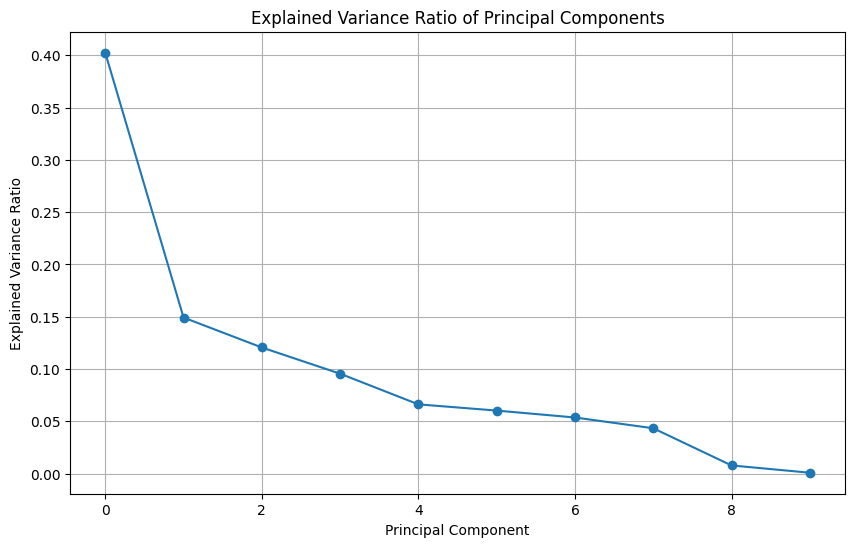

array([0.40242108, 0.14923197, 0.12059663, 0.09554764, 0.06621814,
       0.06027171, 0.05365657, 0.0433682 , 0.007832  , 0.00085607])

In [2]:
#PCA

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import linalg
from scipy.sparse import diags
import scipy.optimize

import autograd
from autograd import grad
import autograd.numpy as numpy
import autograd.numpy.random as npr
def train_pca_svd(input_data):
    X_standardized = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0) # Reguliztion
    U, S, V = linalg.svd(X_standardized)  # SVD decomposition
    print('Input dimensions: {}'.format(input_data.shape))
    print('Left singular vector matrix shape: {}'.format(U.shape))
    print('Right singular vector matrix shape: {}'.format(V.shape))
    print('Singular value matrix shape: {}'.format(S.shape))

    return U,S,V

U,S,V= train_pca_svd(X)
explained_variance = np.power(S, 2) / np.sum(np.power(S, 2))

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.title('Explained Variance Ratio of Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Return the explained variance for further analysis
explained_variance



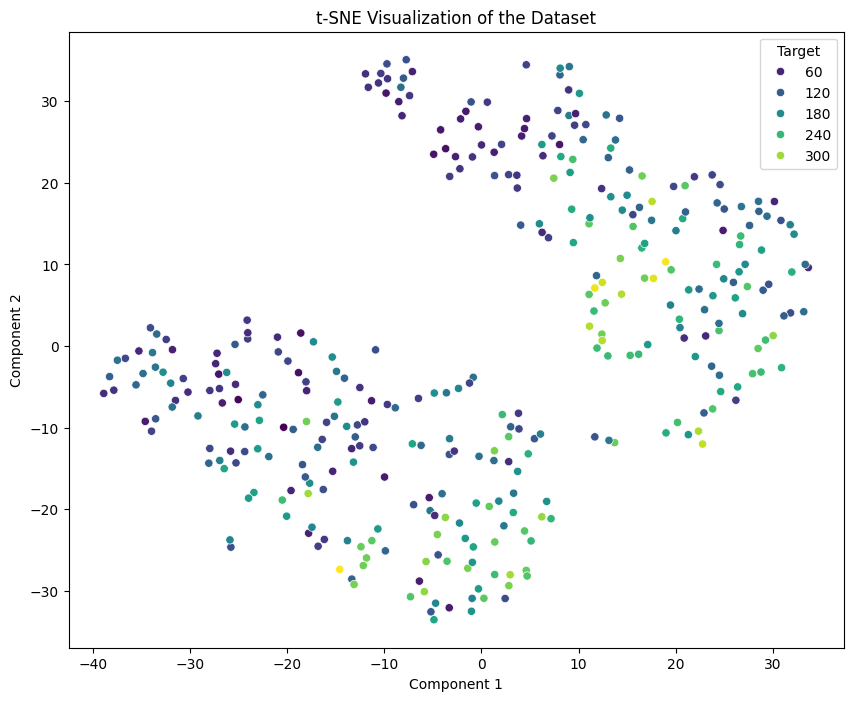

In [3]:
# t-SNE
from sklearn.manifold import TSNE
import seaborn as sns

# Standardize the training data
X_train_standardized = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Apply t-SNE to the standardized training data
tsne = TSNE(n_components=2, random_state=42,perplexity=15)
X_tsne = tsne.fit_transform(X_train_standardized)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'Component 1': X_tsne[:, 0],
    'Component 2': X_tsne[:, 1],
    'Target': y_train
})

# Visualize the results using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Component 1', y='Component 2', hue='Target', palette='viridis')
plt.title('t-SNE Visualization of the Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [4]:
from collections import Counter
from sklearn.metrics import accuracy_score
class KNN:
    def __init__(self, n_neighbors):
        self.k = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Calculate distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]

        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]

        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Return the most common class label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Load the diabetes dataset
diabetes_sklearn = load_diabetes()
## convert the diabete dataset to pandas form
data = pd.DataFrame(data= np.c_[diabetes_sklearn['data'], diabetes_sklearn['target']],
                     columns= diabetes_sklearn['feature_names'] + ['target'])
# Separate the features, target values, and feature names
X = data.drop('target', axis=1)
y = data['target'].values

# Create an imbalanced target variable
y= np.where(y > np.percentile(y, 50), 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Initialize and train the KNN model on the full space
knn1 = KNN(n_neighbors=10) # Use 10 neighbors
knn1.fit(X_train_np, y_train)

# Predict on the test set using the full space model
y_pred1 = knn1.predict(X_test_np)

# Calculate the accuracy on the full space
accuracy_full = accuracy_score(y_test, y_pred1)

# Select the top q=3 singular vectors
U,S,V=train_pca_svd(X)
q = 3
X_reduced = X_train_np @ V[:q, :].T

# Initialize and train the KNN model on the reduced space
knn2 = KNN(n_neighbors=10)
knn2.fit(X_reduced, y_train)

# Predict on the test set using the reduced space model
X_test_reduced = X_test_np @ V[:q, :].T
y_pred2 = knn2.predict(X_test_reduced)

# Calculate the accuracy on the reduced space
accuracy_reduced = accuracy_score(y_test, y_pred2)

accuracy_full, accuracy_reduced

Input dimensions: (442, 10)
Left singular vector matrix shape: (442, 442)
Right singular vector matrix shape: (10, 10)
Singular value matrix shape: (10,)


(0.7303370786516854, 0.7078651685393258)

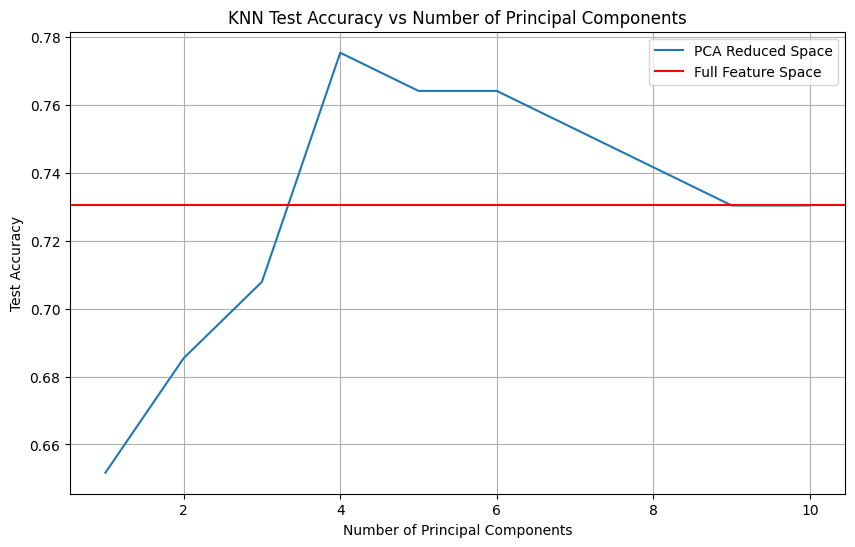

In [5]:
# Define a range of values for the number of principal components
num_components = range(1, X_train_np.shape[1] + 1)
accuracies_reduced = []

# Loop over different numbers of principal components
for q in num_components:
    # Project the training data onto the top q principal components
    X_reduced = X_train_np @ V[:q, :].T
    X_test_reduced = X_test_np @ V[:q, :].T

    # Initialize and train the KNN model on the reduced space
    knn_reduced = KNN(n_neighbors=10)
    knn_reduced.fit(X_reduced, y_train)

    # Predict on the test set using the reduced space model
    y_pred_reduced = knn_reduced.predict(X_test_reduced)

    # Calculate and store the accuracy on the reduced space
    accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
    accuracies_reduced.append(accuracy_reduced)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_components, accuracies_reduced, label='PCA Reduced Space')
plt.axhline(y=accuracy_full, color='r', linestyle='-', label='Full Feature Space')

plt.xlabel('Number of Principal Components')
plt.ylabel('Test Accuracy')
plt.title('KNN Test Accuracy vs Number of Principal Components')
plt.legend()
plt.grid(True)
plt.show()
